In [10]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import os

class StationarityAnalyzer:
    """
    Clase para analizar la estacionariedad de modelos de series de tiempo
    """
    
    def __init__(self):
        self.results = []
        # Crear carpeta para guardar plots
        self.output_dir = "roots"
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
    
    def check_ar_stationarity(self, phi_coeffs: List[float], model_name: str) -> Tuple[bool, List[complex], List[float]]:
        """
        Verifica estacionariedad para modelos AR(p)
        
        Args:
            phi_coeffs: Coeficientes phi del modelo AR [φ1, φ2, ..., φp]
            model_name: Nombre del modelo para reporte
            
        Returns:
            Tuple (es_estacionario, raices, modulos)
        """
        try:
            # Construir el polinomio característico: 1 - φ1*z - φ2*z^2 - ... - φp*z^p = 0
            # numpy.roots requiere coeficientes de MAYOR a MENOR grado
            # Para AR(p): 1 - φ1*z - φ2*z^2 - ... - φp*z^p
            # Coeficientes: [-φp, -φ(p-1), ..., -φ2, -φ1, 1]
            poly_coeffs = [-phi for phi in reversed(phi_coeffs)] + [1.0]
            
            # Encontrar las raíces
            roots = np.roots(poly_coeffs)
            
            # Calcular módulos
            moduli = np.abs(roots)
            
            # Verificar si todas las raíces están ESTRICTAMENTE fuera del círculo unitario
            # Usamos un pequeño epsilon para manejar errores numéricos
            epsilon = 1e-10
            is_stationary = all(mod > 1.0 + epsilon for mod in moduli)
            
            return is_stationary, roots, moduli
            
        except Exception as e:
            print(f"Error analizando {model_name}: {e}")
            return False, np.array([]), np.array([])
    
    def plot_single_model(self, result: Dict, filename: str):
        """
        Crear un plot individual para un modelo mostrando sus raíces y el círculo unitario
        
        Args:
            result: Diccionario con los resultados del modelo
            filename: Nombre del archivo para guardar el plot
        """
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Recolectar todas las raíces para calcular límites dinámicos
        all_reals = []
        all_imags = []
        
        # Determinar el tipo de modelo
        if result['Escenario'] == 'No Lineal':
            # Para modelos no lineales, plotear ambos regímenes
            if len(result['Raices_Bajo']) > 0:
                real_bajo = [r.real for r in result['Raices_Bajo']]
                imag_bajo = [r.imag for r in result['Raices_Bajo']]
                ax.scatter(real_bajo, imag_bajo, s=100, marker='o', 
                          label='Régimen Bajo', alpha=0.7, edgecolors='black', linewidths=2)
                all_reals.extend(real_bajo)
                all_imags.extend(imag_bajo)
            
            if len(result['Raices_Alto']) > 0:
                real_alto = [r.real for r in result['Raices_Alto']]
                imag_alto = [r.imag for r in result['Raices_Alto']]
                ax.scatter(real_alto, imag_alto, s=100, marker='s', 
                          label='Régimen Alto', alpha=0.7, edgecolors='black', linewidths=2)
                all_reals.extend(real_alto)
                all_imags.extend(imag_alto)
        else:
            # Para modelos lineales
            if len(result['Raices']) > 0:
                real = [r.real for r in result['Raices']]
                imag = [r.imag for r in result['Raices']]
                ax.scatter(real, imag, s=100, marker='o', 
                          label='Raíces', alpha=0.7, edgecolors='black', linewidths=2)
                all_reals.extend(real)
                all_imags.extend(imag)
        
        # Dibujar círculo unitario
        theta = np.linspace(0, 2*np.pi, 200)
        ax.plot(np.cos(theta), np.sin(theta), 'r--', linewidth=2, label='Círculo Unitario')
        
        # Ejes
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.5)
        ax.axvline(x=0, color='k', linestyle='-', alpha=0.3, linewidth=0.5)
        
        # Configuración del plot
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Parte Real', fontsize=12)
        ax.set_ylabel('Parte Imaginaria', fontsize=12)
        
        # Título con información de estacionariedad
        status_emoji = "✓" if result['Estacionario'] else "✗"
        title = f"{result['Modelo']} - {result['Status']}\n{status_emoji}"
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        ax.legend(loc='best', fontsize=10)
        
        # Ajustar límites dinámicamente basados en las raíces
        if all_reals and all_imags:
            max_real = max(abs(r) for r in all_reals)
            max_imag = max(abs(i) for i in all_imags)
            max_val = max(max_real, max_imag, 1.5)  # Al menos 1.5 para incluir el círculo unitario
            max_val = max_val * 1.2  # Agregar 20% de margen
        else:
            max_val = 2.5  # Valor por defecto si no hay raíces
        
        ax.set_xlim(-max_val, max_val)
        ax.set_ylim(-max_val, max_val)
        
        plt.tight_layout()
        
        # Guardar el plot
        filepath = os.path.join(self.output_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"  Plot guardado: {filepath}")
    
    def analyze_linear_stationary(self):
        """Analizar modelos del Escenario 1: Estacionario y Lineal"""
        print("=" * 60)
        print("ESCENARIO 1: ESTACIONARIO Y LINEAL")
        print("=" * 60)
        
        models = [
            {'name': 'AR(1)', 'phi': [0.9], 'theta': []},
            {'name': 'AR(2)', 'phi': [0.5, -0.3], 'theta': []},
            {'name': 'MA(1)', 'phi': [], 'theta': [0.7]},
            {'name': 'MA(2)', 'phi': [], 'theta': [0.4, 0.2]},
            {'name': 'ARMA(1,1)', 'phi': [0.6], 'theta': [0.3]},
            {'name': 'ARMA(2,2)', 'phi': [0.4, -0.2], 'theta': [0.5, 0.1]}
        ]
        
        for model in models:
            if model['phi']:  # Tiene componente AR
                stationary, roots, moduli = self.check_ar_stationarity(model['phi'], model['name'])
                status = "ESTACIONARIO" if stationary else "NO ESTACIONARIO"
            else:  # Modelo MA puro
                stationary = True
                roots, moduli = np.array([]), np.array([])
                status = "ESTACIONARIO (MA puro)"
            
            # Guardar resultados
            result = {
                'Escenario': 'Lineal Estacionario',
                'Modelo': model['name'],
                'Estacionario': stationary,
                'Status': status,
                'Raices': roots,
                'Modulos': moduli,
                'Coeficientes': model
            }
            self.results.append(result)
            
            # Mostrar resultados
            print(f"\n{model['name']}:")
            print(f"  Coeficientes φ: {model['phi']}, θ: {model['theta']}")
            print(f"  Status: {status}")
            if model['phi']:
                print(f"  Raíces: {roots}")
                print(f"  Módulos: {moduli}")
    
    def analyze_linear_nonstationary(self):
        """Analizar modelos del Escenario 2: No Estacionario y Lineal"""
        print("\n" + "=" * 60)
        print("ESCENARIO 2: NO ESTACIONARIO Y LINEAL")
        print("=" * 60)
        
        models = [
            {'name': 'ARIMA(0,1,0)', 'phi': [], 'theta': [], 'd': 1},
            {'name': 'ARIMA(1,1,0)', 'phi': [0.6], 'theta': [], 'd': 1},
            {'name': 'ARIMA(2,1,0)', 'phi': [0.5, -0.2], 'theta': [], 'd': 1},
            {'name': 'ARIMA(0,1,1)', 'phi': [], 'theta': [0.5], 'd': 1},
            {'name': 'ARIMA(0,1,2)', 'phi': [], 'theta': [0.4, 0.25], 'd': 1},
            {'name': 'ARIMA(1,1,1)', 'phi': [0.7], 'theta': [-0.3], 'd': 1},
            {'name': 'ARIMA(2,1,2)', 'phi': [0.6, 0.2], 'theta': [0.4, -0.1], 'd': 1}
        ]
        
        for model in models:
            # Modelos ARIMA con d>=1 siempre son no estacionarios
            stationary = False
            status = "NO ESTACIONARIO (ARIMA con d>=1)"
            
            # Aún así verificamos las raíces de la parte AR
            roots, moduli = np.array([]), np.array([])
            if model['phi']:
                stationary_ar, roots, moduli = self.check_ar_stationarity(model['phi'], model['name'])
                # Aunque la parte AR sea estacionaria, el modelo completo no lo es por la integración
            
            # Guardar resultados
            result = {
                'Escenario': 'Lineal No Estacionario',
                'Modelo': model['name'],
                'Estacionario': stationary,
                'Status': status,
                'Raices': roots,
                'Modulos': moduli,
                'Coeficientes': model
            }
            self.results.append(result)
            
            # Mostrar resultados
            print(f"\n{model['name']}:")
            print(f"  Coeficientes φ: {model['phi']}, θ: {model['theta']}, d: {model['d']}")
            print(f"  Status: {status}")
            if model['phi']:
                print(f"  Raíces parte AR: {roots}")
                print(f"  Módulos parte AR: {moduli}")
    
    def analyze_nonlinear(self):
        """Analizar modelos del Escenario 3: No Lineal"""
        print("\n" + "=" * 60)
        print("ESCENARIO 3: NO LINEAL")
        print("=" * 60)
        
        models = [
            {'name': 'SETAR(2,1)', 'phi_low': [0.6], 'phi_high': [-0.5], 'threshold': 0.0, 'delay': 1},
            {'name': 'SETAR(2,2)', 'phi_low': [0.5, -0.2], 'phi_high': [-0.3, 0.1], 'threshold': 0.5, 'delay': 1},
            {'name': 'TAR(2,1)', 'phi_low': [0.7], 'phi_high': [-0.7], 'threshold': 0.0, 'delay': 2},
            {'name': 'TAR(2,2)', 'phi_low': [0.3, 0.1], 'phi_high': [-0.2, -0.1], 'threshold': 1.0, 'delay': 1},
            {'name': 'EXPAR(2,1)', 'phi_low': [0.6], 'phi_high': [-0.4], 'threshold': 0.0, 'delay': 1},
            {'name': 'BILINEAR(1)', 'phi_low': [0.5], 'phi_high': [0.5], 'threshold': 0.0, 'delay': 1},
            {'name': 'SETAR(2,3)', 'phi_low': [0.4, -0.1, 0.05], 'phi_high': [-0.3, 0.1, -0.05], 'threshold': 0.0, 'delay': 1}
        ]
        
        for model in models:
            # Verificar ambos regímenes
            low_stationary, low_roots, low_moduli = self.check_ar_stationarity(
                model['phi_low'], f"{model['name']} (Régimen Bajo)")
            high_stationary, high_roots, high_moduli = self.check_ar_stationarity(
                model['phi_high'], f"{model['name']} (Régimen Alto)")
            
            # El modelo es estacionario si ambos regímenes lo son
            stationary = low_stationary and high_stationary
            status = "ESTACIONARIO" if stationary else "NO ESTACIONARIO"
            
            # Guardar resultados
            result = {
                'Escenario': 'No Lineal',
                'Modelo': model['name'],
                'Estacionario': stationary,
                'Status': status,
                'Raices_Bajo': low_roots,
                'Modulos_Bajo': low_moduli,
                'Raices_Alto': high_roots,
                'Modulos_Alto': high_moduli,
                'Raices': np.array([]),  # Para compatibilidad con plot_single_model
                'Modulos': np.array([]),
                'Coeficientes': model
            }
            self.results.append(result)
            
            # Mostrar resultados
            print(f"\n{model['name']}:")
            print(f"  φ_bajo: {model['phi_low']}, φ_alto: {model['phi_high']}")
            print(f"  Status: {status}")
            print(f"  Régimen bajo - Estacionario: {low_stationary}")
            if model['phi_low']:
                print(f"    Raíces: {low_roots}")
                print(f"    Módulos: {low_moduli}")
            print(f"  Régimen alto - Estacionario: {high_stationary}")
            if model['phi_high']:
                print(f"    Raíces: {high_roots}")
                print(f"    Módulos: {high_moduli}")
    
    def generate_summary_table(self) -> pd.DataFrame:
        """
        Generar tabla resumen con todos los modelos y su estacionariedad
        
        Returns:
            DataFrame con columnas: Modelo, Estacionario (Sí/No)
        """
        table_data = []
        
        for result in self.results:
            row = {
                'Modelo': result['Modelo'],
                'Estacionario': 'Sí' if result['Estacionario'] else 'No',
                'Escenario': result['Escenario']
            }
            table_data.append(row)
        
        df = pd.DataFrame(table_data)
        
        # Reordenar columnas
        df = df[['Modelo', 'Estacionario', 'Escenario']]
        
        return df
    
    def generate_all_plots(self):
        """
        Generar un plot individual para cada modelo analizado
        """
        print("\n" + "=" * 60)
        print("GENERANDO PLOTS INDIVIDUALES")
        print("=" * 60)
        
        for idx, result in enumerate(self.results, 1):
            # Crear nombre de archivo seguro
            safe_name = result['Modelo'].replace('(', '').replace(')', '').replace(',', '_').replace(' ', '_')
            filename = f"{idx:02d}_{safe_name}.png"
            
            print(f"\nGenerando plot {idx}/{len(self.results)}: {result['Modelo']}")
            self.plot_single_model(result, filename)
        
        print(f"\n✓ Todos los plots guardados en la carpeta '{self.output_dir}/'")
    
    def generate_summary(self):
        """Generar resumen de todos los análisis"""
        print("\n" + "=" * 80)
        print("RESUMEN GENERAL")
        print("=" * 80)
        
        df_data = []
        for result in self.results:
            row = {
                'Escenario': result['Escenario'],
                'Modelo': result['Modelo'],
                'Estacionario': result['Estacionario'],
                'Status': result['Status']
            }
            
            # Agregar información específica según el escenario
            if result['Escenario'] == 'No Lineal':
                epsilon = 1e-10
                row['Estacionario_Bajo'] = all(mod > 1.0 + epsilon for mod in result['Modulos_Bajo']) if len(result['Modulos_Bajo']) > 0 else True
                row['Estacionario_Alto'] = all(mod > 1.0 + epsilon for mod in result['Modulos_Alto']) if len(result['Modulos_Alto']) > 0 else True
            else:
                row['Min_Modulo'] = min(result['Modulos']) if len(result['Modulos']) > 0 else float('inf')
            
            df_data.append(row)
        
        df = pd.DataFrame(df_data)
        
        # Resumen por escenario
        print("\nDISTRIBUCIÓN POR ESCENARIO:")
        summary = df.groupby(['Escenario', 'Estacionario']).size().unstack(fill_value=0)
        print(summary)
        
        print("\nDETALLE COMPLETO:")
        for escenario in df['Escenario'].unique():
            print(f"\n{escenario}:")
            escenario_df = df[df['Escenario'] == escenario]
            for _, row in escenario_df.iterrows():
                status_color = "✓" if row['Estacionario'] else "✗"
                print(f"  {status_color} {row['Modelo']}: {row['Status']}")
    
    def run_complete_analysis(self) -> pd.DataFrame:
        """
        Ejecutar análisis completo
        
        Returns:
            DataFrame con tabla resumen de estacionariedad
        """
        # Realizar análisis
        self.analyze_linear_stationary()
        self.analyze_linear_nonstationary()
        self.analyze_nonlinear()
        self.generate_summary()
        
        # Generar tabla resumen
        print("\n" + "=" * 80)
        print("TABLA RESUMEN DE ESTACIONARIEDAD")
        print("=" * 80)
        summary_table = self.generate_summary_table()
        print("\n" + summary_table.to_string(index=False))
        
        # Guardar tabla en CSV
        csv_path = os.path.join(self.output_dir, "resumen_estacionariedad.csv")
        summary_table.to_csv(csv_path, index=False)
        print(f"\n✓ Tabla guardada en: {csv_path}")
        
        # Generar todos los plots
        self.generate_all_plots()
        
        print("\n" + "=" * 80)
        print("ANÁLISIS COMPLETADO")
        print("=" * 80)
        
        # Estadísticas finales
        total = len(self.results)
        estacionarios = sum(1 for r in self.results if r['Estacionario'])
        no_estacionarios = total - estacionarios
        
        print(f"\nESTADÍSTICAS FINALES:")
        print(f"Total de modelos analizados: {total}")
        print(f"Modelos estacionarios: {estacionarios} ({estacionarios/total*100:.1f}%)")
        print(f"Modelos no estacionarios: {no_estacionarios} ({no_estacionarios/total*100:.1f}%)")
        print(f"\nArchivos generados:")
        print(f"  - Tabla resumen: {csv_path}")
        print(f"  - Plots individuales: {total} archivos en carpeta '{self.output_dir}/'")
        
        return summary_table

# Ejecutar el análisis
if __name__ == "__main__":
    analyzer = StationarityAnalyzer()
    summary_df = analyzer.run_complete_analysis()
    
    print("\n" + "=" * 80)
    print("¡Análisis finalizado exitosamente!")
    print("=" * 80)

ESCENARIO 1: ESTACIONARIO Y LINEAL

AR(1):
  Coeficientes φ: [0.9], θ: []
  Status: ESTACIONARIO
  Raíces: [1.11111111]
  Módulos: [1.11111111]

AR(2):
  Coeficientes φ: [0.5, -0.3], θ: []
  Status: ESTACIONARIO
  Raíces: [0.83333333+1.62446572j 0.83333333-1.62446572j]
  Módulos: [1.82574186 1.82574186]

MA(1):
  Coeficientes φ: [], θ: [0.7]
  Status: ESTACIONARIO (MA puro)

MA(2):
  Coeficientes φ: [], θ: [0.4, 0.2]
  Status: ESTACIONARIO (MA puro)

ARMA(1,1):
  Coeficientes φ: [0.6], θ: [0.3]
  Status: ESTACIONARIO
  Raíces: [1.66666667]
  Módulos: [1.66666667]

ARMA(2,2):
  Coeficientes φ: [0.4, -0.2], θ: [0.5, 0.1]
  Status: ESTACIONARIO
  Raíces: [1.+2.j 1.-2.j]
  Módulos: [2.23606798 2.23606798]

ESCENARIO 2: NO ESTACIONARIO Y LINEAL

ARIMA(0,1,0):
  Coeficientes φ: [], θ: [], d: 1
  Status: NO ESTACIONARIO (ARIMA con d>=1)

ARIMA(1,1,0):
  Coeficientes φ: [0.6], θ: [], d: 1
  Status: NO ESTACIONARIO (ARIMA con d>=1)
  Raíces parte AR: [1.66666667]
  Módulos parte AR: [1.66666667

# No lineal


████████████████████████████████████████████████████████████████████████████████
ANÁLISIS DE ESTACIONARIEDAD - MODELOS SETAR DEL CÓDIGO
████████████████████████████████████████████████████████████████████████████████

ANÁLISIS DE ESTACIONARIEDAD - MODELO SETAR
φ_low  = [0.6]
φ_high = [-0.5]
Umbral = 0.0, Retardo = 1

1. CONDICIONES TEÓRICAS DE ESTACIONARIEDAD
----------------------------------------------------------------------

RÉGIMEN BAJO (Y_{t-d} ≤ 0.0):
  • Coeficiente: φ = 0.6000
  • Condición: |φ| = 0.6000 < 1
  • Estacionario: ✓ SÍ

RÉGIMEN ALTO (Y_{t-d} > 0.0):
  • Coeficiente: φ = -0.5000
  • Condición: |φ| = 0.5000 < 1
  • Estacionario: ✓ SÍ

2. PRUEBAS ESTADÍSTICAS (sobre serie simulada)
----------------------------------------------------------------------

Augmented Dickey-Fuller Test:
  • Estadístico: -41.1784
  • P-valor: 0.0000
  • Valores críticos: {'1%': np.float64(-3.431659055967043), '5%': np.float64(-2.862118461132801), '10%': np.float64(-2.5670779155711902)}
  

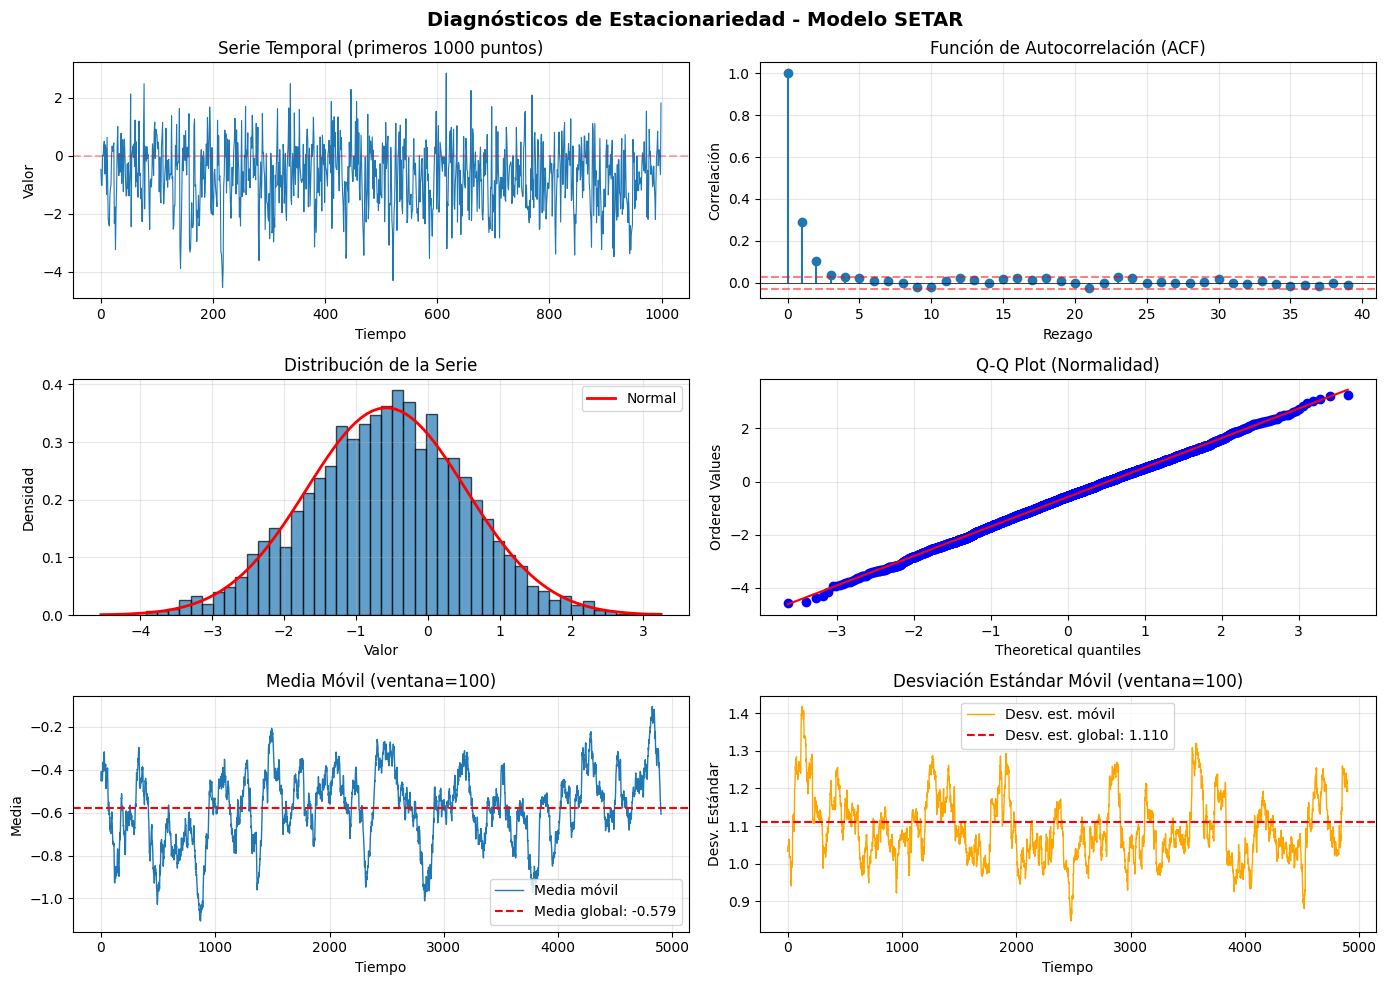

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

class SETARStationarityAnalyzer:
    """
    Analiza la estacionariedad de modelos SETAR mediante:
    1. Pruebas estadísticas (ADF, KPSS)
    2. Condiciones teóricas sobre coeficientes AR
    3. Análisis de momentos (media, varianza)
    4. Visualización
    """
    
    def __init__(self, phi_low: List[float], phi_high: List[float], 
                 threshold: float = 0.0, delay: int = 1, 
                 sigma: float = 1.0, seed: int = 42):
        self.phi_low = np.array(phi_low)
        self.phi_high = np.array(phi_high)
        self.threshold = threshold
        self.delay = delay
        self.sigma = sigma
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        
    def simulate_setar(self, n: int = 5000, burn_in: int = 1000) -> np.ndarray:
        """Simula una serie SETAR."""
        total_length = n + burn_in
        p = max(len(self.phi_low), len(self.phi_high), self.delay)
        
        errors = self.rng.normal(0, self.sigma, total_length)
        series = np.zeros(total_length)
        series[:p] = self.rng.normal(0, self.sigma, p)
        
        for t in range(p, total_length):
            threshold_var = series[t - self.delay]
            regime = 1 if threshold_var > self.threshold else 0
            phi = self.phi_high if regime == 1 else self.phi_low
            
            ar_part = 0
            for lag in range(len(phi)):
                if t - lag - 1 >= 0:
                    ar_part += phi[lag] * series[t - lag - 1]
            
            series[t] = ar_part + errors[t]
        
        return series[burn_in:]
    
    def check_ar_stationarity(self, phi: np.ndarray) -> Dict:
        """
        Verifica condiciones de estacionariedad para un proceso AR(p).
        Para AR(1): |φ| < 1
        Para AR(p): Raíces del polinomio característico fuera del círculo unitario
        """
        p = len(phi)
        
        if p == 1:
            stationary = abs(phi[0]) < 1
            return {
                'order': 1,
                'stationary': stationary,
                'coefficient': phi[0],
                'condition': f'|φ| = {abs(phi[0]):.4f} < 1',
                'satisfied': stationary
            }
        else:
            # Para AR(p): 1 - φ₁z - φ₂z² - ... - φₚzᵖ = 0
            # Raíces deben estar fuera del círculo unitario
            poly_coeffs = np.concatenate([[1], -phi])
            roots = np.roots(poly_coeffs)
            moduli = np.abs(roots)
            stationary = np.all(moduli > 1)
            
            return {
                'order': p,
                'stationary': stationary,
                'roots': roots,
                'moduli': moduli,
                'min_modulus': np.min(moduli),
                'condition': 'Todas las raíces fuera del círculo unitario',
                'satisfied': stationary
            }
    
    def statistical_tests(self, series: np.ndarray) -> Dict:
        """Aplica pruebas estadísticas de estacionariedad."""
        # ADF Test (H0: serie tiene raíz unitaria, no estacionaria)
        adf_result = adfuller(series, autolag='AIC')
        adf_stationary = adf_result[1] < 0.05  # p-value < 0.05
        
        # KPSS Test (H0: serie es estacionaria)
        kpss_result = kpss(series, regression='c', nlags='auto')
        kpss_stationary = kpss_result[1] > 0.05  # p-value > 0.05
        
        return {
            'adf': {
                'statistic': adf_result[0],
                'pvalue': adf_result[1],
                'critical_values': adf_result[4],
                'stationary': adf_stationary
            },
            'kpss': {
                'statistic': kpss_result[0],
                'pvalue': kpss_result[1],
                'critical_values': kpss_result[3],
                'stationary': kpss_stationary
            },
            'both_agree': adf_stationary and kpss_stationary
        }
    
    def moment_analysis(self, n_simulations: int = 100, n_points: int = 2000) -> Dict:
        """Analiza estabilidad de momentos mediante múltiples simulaciones."""
        means = []
        variances = []
        
        for _ in range(n_simulations):
            series = self.simulate_setar(n=n_points, burn_in=500)
            means.append(np.mean(series))
            variances.append(np.var(series))
        
        means = np.array(means)
        variances = np.array(variances)
        
        # Estacionariedad implica momentos estables
        mean_stable = np.std(means) / (np.abs(np.mean(means)) + 1e-10) < 0.5
        var_stable = np.std(variances) / (np.mean(variances) + 1e-10) < 0.5
        
        return {
            'mean': {
                'average': np.mean(means),
                'std': np.std(means),
                'stable': mean_stable
            },
            'variance': {
                'average': np.mean(variances),
                'std': np.std(variances),
                'stable': var_stable
            },
            'moments_stable': mean_stable and var_stable
        }
    
    def full_analysis(self) -> Dict:
        """Análisis completo de estacionariedad."""
        print("=" * 70)
        print(f"ANÁLISIS DE ESTACIONARIEDAD - MODELO SETAR")
        print("=" * 70)
        print(f"φ_low  = {self.phi_low}")
        print(f"φ_high = {self.phi_high}")
        print(f"Umbral = {self.threshold}, Retardo = {self.delay}")
        print("=" * 70)
        
        # 1. Condiciones teóricas por régimen
        print("\n1. CONDICIONES TEÓRICAS DE ESTACIONARIEDAD")
        print("-" * 70)
        
        low_result = self.check_ar_stationarity(self.phi_low)
        high_result = self.check_ar_stationarity(self.phi_high)
        
        print(f"\nRÉGIMEN BAJO (Y_{{t-d}} ≤ {self.threshold}):")
        if low_result['order'] == 1:
            print(f"  • Coeficiente: φ = {low_result['coefficient']:.4f}")
            print(f"  • Condición: {low_result['condition']}")
        else:
            print(f"  • Orden AR: p = {low_result['order']}")
            print(f"  • Módulos de raíces: {low_result['moduli']}")
            print(f"  • Mínimo módulo: {low_result['min_modulus']:.4f} (debe ser > 1)")
        print(f"  • Estacionario: {'✓ SÍ' if low_result['stationary'] else '✗ NO'}")
        
        print(f"\nRÉGIMEN ALTO (Y_{{t-d}} > {self.threshold}):")
        if high_result['order'] == 1:
            print(f"  • Coeficiente: φ = {high_result['coefficient']:.4f}")
            print(f"  • Condición: {high_result['condition']}")
        else:
            print(f"  • Orden AR: p = {high_result['order']}")
            print(f"  • Módulos de raíces: {high_result['moduli']}")
            print(f"  • Mínimo módulo: {high_result['min_modulus']:.4f} (debe ser > 1)")
        print(f"  • Estacionario: {'✓ SÍ' if high_result['stationary'] else '✗ NO'}")
        
        theory_stationary = low_result['stationary'] and high_result['stationary']
        
        # 2. Simulación y pruebas estadísticas
        print("\n2. PRUEBAS ESTADÍSTICAS (sobre serie simulada)")
        print("-" * 70)
        series = self.simulate_setar(n=5000, burn_in=1000)
        stat_tests = self.statistical_tests(series)
        
        print(f"\nAugmented Dickey-Fuller Test:")
        print(f"  • Estadístico: {stat_tests['adf']['statistic']:.4f}")
        print(f"  • P-valor: {stat_tests['adf']['pvalue']:.4f}")
        print(f"  • Valores críticos: {stat_tests['adf']['critical_values']}")
        print(f"  • Conclusión: {'✓ Estacionaria' if stat_tests['adf']['stationary'] else '✗ No estacionaria'}")
        
        print(f"\nKPSS Test:")
        print(f"  • Estadístico: {stat_tests['kpss']['statistic']:.4f}")
        print(f"  • P-valor: {stat_tests['kpss']['pvalue']:.4f}")
        print(f"  • Valores críticos: {stat_tests['kpss']['critical_values']}")
        print(f"  • Conclusión: {'✓ Estacionaria' if stat_tests['kpss']['stationary'] else '✗ No estacionaria'}")
        
        print(f"\n  • Ambas pruebas concuerdan: {'✓ SÍ' if stat_tests['both_agree'] else '✗ NO'}")
        
        # 3. Análisis de momentos
        print("\n3. ESTABILIDAD DE MOMENTOS (100 simulaciones)")
        print("-" * 70)
        moments = self.moment_analysis(n_simulations=100, n_points=2000)
        
        print(f"\nMedia:")
        print(f"  • Promedio: {moments['mean']['average']:.4f}")
        print(f"  • Desv. estándar: {moments['mean']['std']:.4f}")
        print(f"  • Estable: {'✓ SÍ' if moments['mean']['stable'] else '✗ NO'}")
        
        print(f"\nVarianza:")
        print(f"  • Promedio: {moments['variance']['average']:.4f}")
        print(f"  • Desv. estándar: {moments['variance']['std']:.4f}")
        print(f"  • Estable: {'✓ SÍ' if moments['variance']['stable'] else '✗ NO'}")
        
        # 4. Conclusión final
        print("\n" + "=" * 70)
        print("CONCLUSIÓN FINAL")
        print("=" * 70)
        
        all_criteria = [
            ("Condiciones teóricas", theory_stationary),
            ("Pruebas estadísticas", stat_tests['both_agree']),
            ("Estabilidad de momentos", moments['moments_stable'])
        ]
        
        for criterion, result in all_criteria:
            status = "✓ CUMPLE" if result else "✗ NO CUMPLE"
            print(f"{criterion:.<40} {status}")
        
        overall = all([result for _, result in all_criteria])
        print("\n" + "=" * 70)
        if overall:
            print("🎯 EL MODELO ES ESTACIONARIO")
        else:
            print("⚠️  EL MODELO PUEDE NO SER ESTACIONARIO")
        print("=" * 70)
        
        return {
            'theoretical': {'low': low_result, 'high': high_result, 'overall': theory_stationary},
            'statistical': stat_tests,
            'moments': moments,
            'series': series,
            'stationary': overall
        }
    
    def plot_diagnostics(self, results: Dict):
        """Visualiza diagnósticos de estacionariedad."""
        series = results['series']
        
        fig, axes = plt.subplots(3, 2, figsize=(14, 10))
        fig.suptitle('Diagnósticos de Estacionariedad - Modelo SETAR', 
                     fontsize=14, fontweight='bold')
        
        # 1. Serie temporal
        axes[0, 0].plot(series[:1000], linewidth=0.8)
        axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
        axes[0, 0].set_title('Serie Temporal (primeros 1000 puntos)')
        axes[0, 0].set_xlabel('Tiempo')
        axes[0, 0].set_ylabel('Valor')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. ACF visual (correlación con rezagos)
        max_lag = 40
        acf_values = [np.corrcoef(series[:-i], series[i:])[0, 1] if i > 0 else 1 
                      for i in range(max_lag)]
        axes[0, 1].stem(range(max_lag), acf_values, basefmt=' ')
        axes[0, 1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        axes[0, 1].axhline(y=1.96/np.sqrt(len(series)), color='r', linestyle='--', alpha=0.5)
        axes[0, 1].axhline(y=-1.96/np.sqrt(len(series)), color='r', linestyle='--', alpha=0.5)
        axes[0, 1].set_title('Función de Autocorrelación (ACF)')
        axes[0, 1].set_xlabel('Rezago')
        axes[0, 1].set_ylabel('Correlación')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Histograma
        axes[1, 0].hist(series, bins=50, density=True, alpha=0.7, edgecolor='black')
        mu, sigma = series.mean(), series.std()
        x = np.linspace(series.min(), series.max(), 100)
        axes[1, 0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
        axes[1, 0].set_title('Distribución de la Serie')
        axes[1, 0].set_xlabel('Valor')
        axes[1, 0].set_ylabel('Densidad')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Q-Q plot
        stats.probplot(series, dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title('Q-Q Plot (Normalidad)')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 5. Media móvil (estabilidad)
        window = 100
        rolling_mean = np.convolve(series, np.ones(window)/window, mode='valid')
        rolling_std = np.array([np.std(series[i:i+window]) for i in range(len(series)-window+1)])
        
        axes[2, 0].plot(rolling_mean, label='Media móvil', linewidth=1)
        axes[2, 0].axhline(y=series.mean(), color='r', linestyle='--', 
                          label=f'Media global: {series.mean():.3f}')
        axes[2, 0].set_title(f'Media Móvil (ventana={window})')
        axes[2, 0].set_xlabel('Tiempo')
        axes[2, 0].set_ylabel('Media')
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)
        
        # 6. Varianza móvil (estabilidad)
        axes[2, 1].plot(rolling_std, label='Desv. est. móvil', linewidth=1, color='orange')
        axes[2, 1].axhline(y=series.std(), color='r', linestyle='--', 
                          label=f'Desv. est. global: {series.std():.3f}')
        axes[2, 1].set_title(f'Desviación Estándar Móvil (ventana={window})')
        axes[2, 1].set_xlabel('Tiempo')
        axes[2, 1].set_ylabel('Desv. Estándar')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig


# ============================================================================
# CASOS DE PRUEBA: Los 5 modelos SETAR del código
# ============================================================================

print("\n" + "█" * 80)
print("ANÁLISIS DE ESTACIONARIEDAD - MODELOS SETAR DEL CÓDIGO")
print("█" * 80 + "\n")

models = [
    ("SETAR-1", [0.6], [-0.5], 0.0, 1),
    ("SETAR-2", [0.5, -0.2], [-0.3, 0.1], 0.5, 1),
    ("SETAR-3", [0.4, -0.1, 0.05], [-0.3, 0.1, -0.05], 0.0, 1),
    ("SETAR-4", [0.7], [-0.7], 0.0, 2),
    ("SETAR-5", [0.3, 0.1], [-0.2, -0.1], 1.0, 1),
]

results_summary = []

for name, phi_low, phi_high, threshold, delay in models:
    analyzer = SETARStationarityAnalyzer(
        phi_low=phi_low,
        phi_high=phi_high,
        threshold=threshold,
        delay=delay,
        sigma=1.0,
        seed=42
    )
    
    results = analyzer.full_analysis()
    results_summary.append({
        'name': name,
        'stationary': results['stationary'],
        'theory': results['theoretical']['overall'],
        'statistical': results['statistical']['both_agree'],
        'moments': results['moments']['moments_stable']
    })
    
    # Visualizar solo el primero como ejemplo
    if name == "SETAR-1":
        fig = analyzer.plot_diagnostics(results)
        plt.savefig('setar_diagnostics_example.png', dpi=150, bbox_inches='tight')
        print("\n📊 Gráficos guardados en 'setar_diagnostics_example.png'")
    
    print("\n")

# Resumen final
print("\n" + "█" * 80)
print("RESUMEN FINAL DE TODOS LOS MODELOS")
print("█" * 80 + "\n")

print(f"{'Modelo':<12} {'Teoría':<10} {'Estadística':<15} {'Momentos':<12} {'Conclusión':<15}")
print("-" * 80)

for r in results_summary:
    theory = "✓" if r['theory'] else "✗"
    stat = "✓" if r['statistical'] else "✗"
    mom = "✓" if r['moments'] else "✗"
    conclusion = "ESTACIONARIO" if r['stationary'] else "NO ESTACIONARIO"
    print(f"{r['name']:<12} {theory:<10} {stat:<15} {mom:<12} {conclusion:<15}")

print("\n" + "█" * 80)
stationary_count = sum([1 for r in results_summary if r['stationary']])
print(f"✓ Modelos estacionarios: {stationary_count}/{len(models)}")
print("█" * 80 + "\n")

plt.show()